In [4]:
import pickle
from pathlib import Path

import numpy as np

In [5]:
downloads_path = Path("/lea/downloads")
file_path = downloads_path / "Violeta_Cespedes Izquierdo_subject_matrices(1).pkl"
with file_path.open("rb") as file_handle:
    data = pickle.load(file_handle)

In [6]:
del data["sub-01"]

In [7]:
from nilearn import datasets

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
    n_rois=400, yeo_networks=7, resolution_mm=1
)
schaefer_atlas_labels = list(map(bytes.decode, schaefer_atlas["labels"]))

In [8]:
from itertools import chain


subjects = sorted(data.keys())
pipelines = sorted(set(chain.from_iterable(d.keys() for d in data.values())))
iterations = min(len(b) for a in data.values() for b in a.values())
(k,) = set(
    chain.from_iterable(c.shape for a in data.values() for b in a.values() for c in b)
)

len(subjects), len(pipelines), iterations, k

(2, 12, 99, 400)

In [9]:
indices = np.tril_indices(k, -1)
labels = np.array(
    [
        f"{schaefer_atlas_labels[i]}, {schaefer_atlas_labels[j]}"
        for i, j in zip(*indices)
    ]
)
labels

array(['7Networks_LH_Vis_2, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_2', ...,
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_6',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_7',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_8'],
      dtype='<U76')

In [10]:
arrays = []

for subject in subjects:
    subject_arrays = []
    for pipeline in pipelines:
        array = np.dstack(data[subject][pipeline])[
            *indices, :iterations, np.newaxis, np.newaxis
        ]

        subject_arrays.append(array)
    subject_array = np.concatenate(subject_arrays, axis=2)
    arrays.append(subject_array)
array = np.concatenate(arrays, axis=3)
array.shape

(79800, 99, 12, 2)

In [11]:
import xarray as xr

ds = xr.Dataset(
    {"functional_connectivity": (["cell", "iteration", "pipeline", "subject"], array)},
    coords=dict(
        cell=labels, iteration=range(iterations), pipeline=pipelines, subject=subjects
    ),
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:                  (cell: 79800, iteration: 99, pipeline: 12,
                              subject: 2)
Coordinates:
  * cell                     (cell) <U76 24MB '7Networks_LH_Vis_2, 7Networks_...
  * iteration                (iteration) int64 792B 0 1 2 3 4 ... 94 95 96 97 98
  * pipeline                 (pipeline) <U10 480B 'FalseComb0' ... 'TrueComb5'
  * subject                  (subject) <U9 72B 'sub-13192' 'sub-9040'
Data variables:
    functional_connectivity  (cell, iteration, pipeline, subject) float64 2GB ...

array([False, False, False, ..., False, False, False])

In [77]:
s = np.asarray(ds.functional_connectivity.std(axis=(1)))
mask = np.isnan(s).any(axis=(1, 2))
s[mask, :, :] = -np.inf
np.unravel_index(np.argmax(s), s.shape)

/lea/micromamba/envs/xarray/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(np.int64(59334), np.int64(11), np.int64(0))

In [82]:
s[mask, :, :] = np.inf
s[s == 0] = np.inf
np.unravel_index(np.argmin(s), s.shape)

(np.int64(22805), np.int64(2), np.int64(0))

In [83]:
ds.functional_connectivity[22805, :, 2, 0]

<xarray.DataArray 'functional_connectivity' (iteration: 99)> Size: 792B
array([0.90341861, 0.90272864, 0.90324164, 0.90353634, 0.90341874,
       0.90315906, 0.90347519, 0.90347125, 0.90305748, 0.90363081,
       0.90368012, 0.90328443, 0.90327187, 0.90332964, 0.90340273,
       0.90337179, 0.90362081, 0.90246443, 0.90344657, 0.90347884,
       0.9032726 , 0.90314388, 0.90334461, 0.90336514, 0.90327132,
       0.90376341, 0.90379283, 0.90326485, 0.90326555, 0.90335303,
       0.90346163, 0.90366304, 0.90351319, 0.90338732, 0.90356269,
       0.90336924, 0.90272478, 0.9033858 , 0.90324993, 0.90362702,
       0.9035121 , 0.90358546, 0.90371453, 0.90298798, 0.90331703,
       0.90325316, 0.90350254, 0.90352857, 0.90341924, 0.90338449,
       0.90364307, 0.90343532, 0.903437  , 0.90357292, 0.90340208,
       0.90324954, 0.90340474, 0.90352673, 0.90339076, 0.90353247,
       0.90335965, 0.90337431, 0.90334408, 0.90363232, 0.90358799,
       0.90347707, 0.90318375, 0.90337665, 0.90347625, 0.90338782,
       0.9036733 , 0.90345168, 0.90339017, 0.90324605, 0.90347422,
       0.90309464, 0.90344089, 0.90323704, 0.90336116, 0.90403307,
       0.90321777, 0.90357231, 0.90323478, 0.903289  , 0.90332643,
       0.90326614, 0.90347293, 0.90338532, 0.90380926, 0.90314572,
       0.90344478, 0.90326133, 0.90339459, 0.90354572, 0.903469  ,
       0.90355723, 0.9033914 , 0.90345439, 0.90337509])
Coordinates:
    cell       <U76 304B '7Networks_RH_Vis_15, 7Networks_LH_Vis_15'
  * iteration  (iteration) int64 792B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98
    pipeline   <U10 40B 'FalseComb2'
    subject    <U9 36B 'sub-13192'

<Axes: ylabel='Count'>

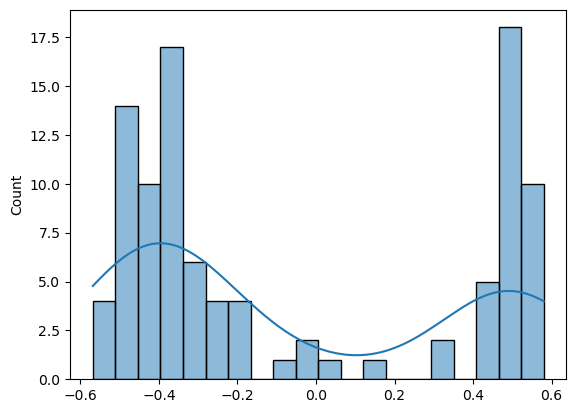

In [62]:
import seaborn as sns

sns.histplot(
    ds.functional_connectivity[59334, :, 11, 0], bins=20, kde=True, stat="count"
)

In [89]:
from significantdigits import significant_digits

x = np.atanh(ds.functional_connectivity[59334, :, 11, 0])
significant_digits(x, x.mean())

array(-4.06656346)

In [88]:
x.mean()

<xarray.DataArray 'functional_connectivity' ()> Size: 8B
array(-0.06337109)
Coordinates:
    cell      <U76 304B '7Networks_RH_Cont_PFCl_5, 7Networks_RH_Cont_Temp_2'
    pipeline  <U10 40B 'TrueComb5'
    subject   <U9 36B 'sub-13192'

In [85]:
x = ds.functional_connectivity[22805, :, 2, 0]
significant_digits(x, x.mean())

array(10.84574902)

In [101]:
x.mean().dtype

dtype('float64')

In [203]:
from matplotlib.axes import Axes


def make_sigdigs_vector(pipeline_index: int, subject_index: int = 0):
    x = np.asarray(ds.functional_connectivity[:, :, pipeline_index, subject_index]).transpose()
    x.shape
    sigdigs = significant_digits(x, x.mean(axis=0), dtype=x.dtype, basis=10)
    sigdigs, sigdigs.shape
    invalid = np.isfinite(x).sum(axis=0) < 90
    sigdigs[invalid] = np.nan
    return sigdigs


def make_sigdigs_array(pipeline_index: int, subject_index: int = 0):
    array = np.full(fill_value=np.nan, shape=(k, k))
    array[*np.tril_indices(k, -1)] = make_sigdigs_vector(pipeline_index, subject_index)
    return array

def make_sigdigs_plot(title: str, ax: Axes, pipeline_index: int, subject_index: int = 0):
    array = make_sigdigs_array(pipeline_index, subject_index)
    sns.heatmap(array, vmax=4, vmin=-4, cmap="RdYlGn", ax=ax, )
    ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")

In [194]:
list(enumerate(pipelines))

[(0, 'FalseComb0'),
 (1, 'FalseComb1'),
 (2, 'FalseComb2'),
 (3, 'FalseComb3'),
 (4, 'FalseComb4'),
 (5, 'FalseComb5'),
 (6, 'TrueComb0'),
 (7, 'TrueComb1'),
 (8, 'TrueComb2'),
 (9, 'TrueComb3'),
 (10, 'TrueComb4'),
 (11, 'TrueComb5')]

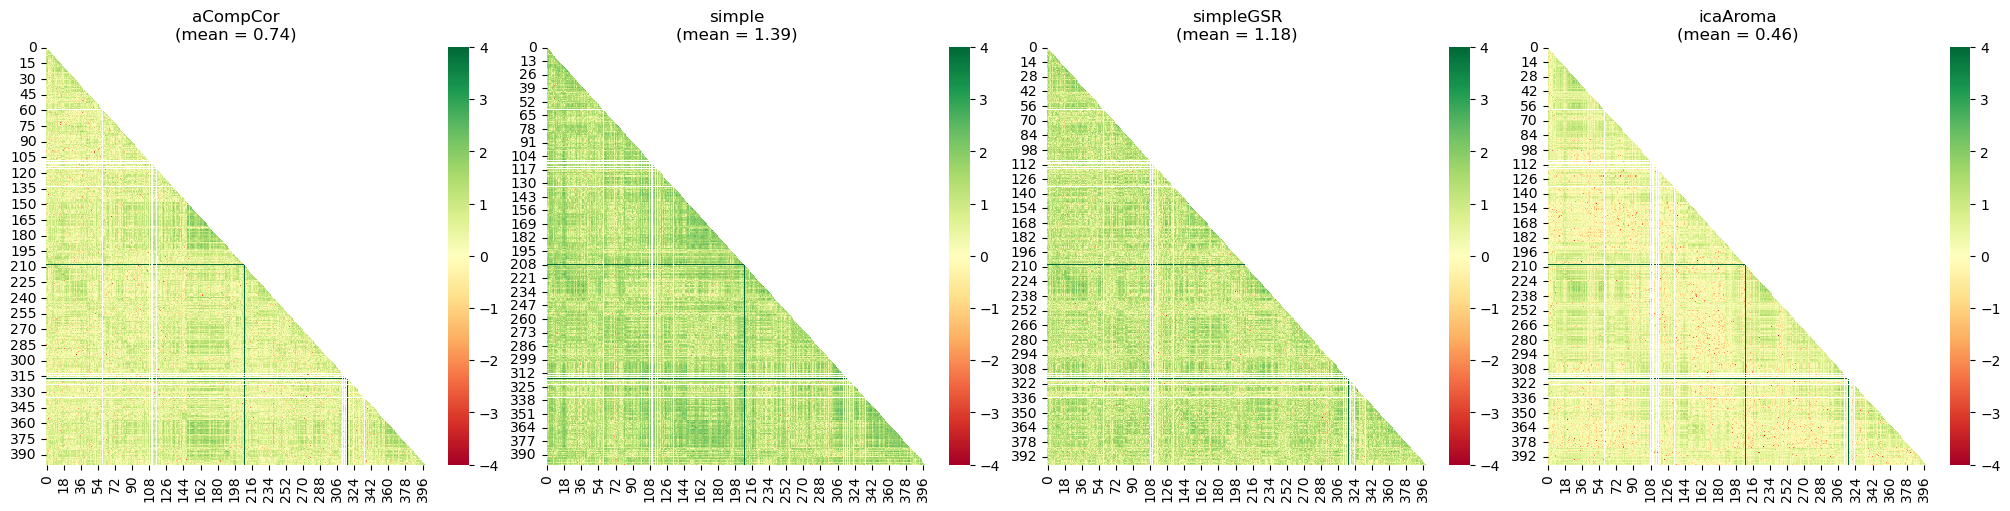

In [205]:
from matplotlib import pyplot as plt

figure, axes_array = plt.subplots(
    ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True
)

subject_index = 1
make_sigdigs_plot("aCompCor", axes_array[0], 1, subject_index)
make_sigdigs_plot("simple", axes_array[1], 3, subject_index)
make_sigdigs_plot("simpleGSR", axes_array[2], 4, subject_index)
make_sigdigs_plot("icaAroma", axes_array[3], 6, subject_index)

In [191]:
import scipy.stats

scipy.stats.ttest_rel(make_sigdigs_vector(1), make_sigdigs_vector(6), nan_policy="omit")

TtestResult(statistic=np.float64(160.65553862241066), pvalue=np.float64(0.0), df=np.int64(66065))

In [192]:
import numpy.ma as ma

a, b = make_sigdigs_vector(1, 1), make_sigdigs_vector(6, 1)
ma.corrcoef(ma.masked_invalid(a), ma.masked_invalid(b))

masked_array(
  data=[[1.0, 0.8923432072561723],
        [0.8923432072561723, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

(-2.0, 3.0)

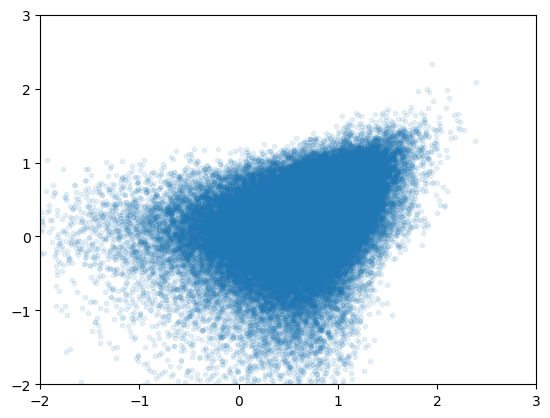

In [181]:
plt.plot(make_sigdigs_vector(1), make_sigdigs_vector(6), ".", alpha=0.1)
plt.ylim(-2, 3)
plt.xlim(-2, 3)

In [169]:
np.nanmean(make_signdigs_array(1)), np.nanmean(make_signdigs_array(6))

(np.float64(0.7506430485664511), np.float64(0.3567614650303614))

In [13]:
# ds.to_netcdf(
#     "/lea/downloads/saved_on_disk.h5",
#     engine="h5netcdf",
#     encoding=dict(
#         functional_connectivity=dict(
#             compression="gzip", compression_opts=9, shuffle=True
#         )
#     ),
# )

In [14]:
mean = ds.functional_connectivity.mean(axis=(1))

In [15]:
ds.functional_connectivity[:, :, 0, 0].shape, mean[:, 0, 0, np.newaxis].shape

IndexError: too many indices

In [ ]:
xr.corr(ds.functional_connectivity[:, :, 0, 0], mean[:, 0, 0], dim="cell")

<xarray.DataArray 'functional_connectivity' (iteration: 99)> Size: 792B
array([0.99982326, 0.99931724, 0.9996751 , 0.99970129, 0.99952022,
       0.99942229, 0.99977459, 0.99949072, 0.99955991, 0.99940251,
       0.99959767, 0.99963524, 0.99976773, 0.99965959, 0.99984058,
       0.99934048, 0.99932854, 0.99944862, 0.999397  , 0.99962732,
       0.99969317, 0.99965707, 0.99949679, 0.99920558, 0.9997906 ,
       0.99966835, 0.999463  , 0.99958915, 0.99954945, 0.99961974,
       0.99969024, 0.99970773, 0.99948551, 0.99948741, 0.99957589,
       0.99958548, 0.99901994, 0.9990928 , 0.99963703, 0.99951295,
       0.99955257, 0.99983634, 0.99954637, 0.9981444 , 0.999412  ,
       0.99970144, 0.9996937 , 0.99911004, 0.99973923, 0.99971518,
       0.99953405, 0.99952107, 0.99961695, 0.99964041, 0.99936543,
       0.99940147, 0.99968351, 0.99966821, 0.99978557, 0.9995491 ,
       0.99951418, 0.99953647, 0.99970688, 0.99969992, 0.99957998,
       0.99947727, 0.99966763, 0.99940096, 0.99973841, 0.99930066,
       0.99956735, 0.99962716, 0.99977622, 0.999702  , 0.99967895,
       0.99955864, 0.99976999, 0.99963841, 0.99926624, 0.99921161,
       0.9992138 , 0.9997018 , 0.99966359, 0.99966461, 0.99976446,
       0.99981174, 0.99976459, 0.99974809, 0.99965043, 0.99932622,
       0.99961967, 0.99965842, 0.99975644, 0.99969217, 0.99970007,
       0.9996936 , 0.99972073, 0.999758  , 0.99914533])
Coordinates:
  * iteration  (iteration) int64 792B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98
    pipeline   <U10 40B 'FalseComb0'
    subject    <U9 36B 'sub-13192'

In [ ]:
np.corrcoef(ds.functional_connectivity[:, :, 0, 0]).shape